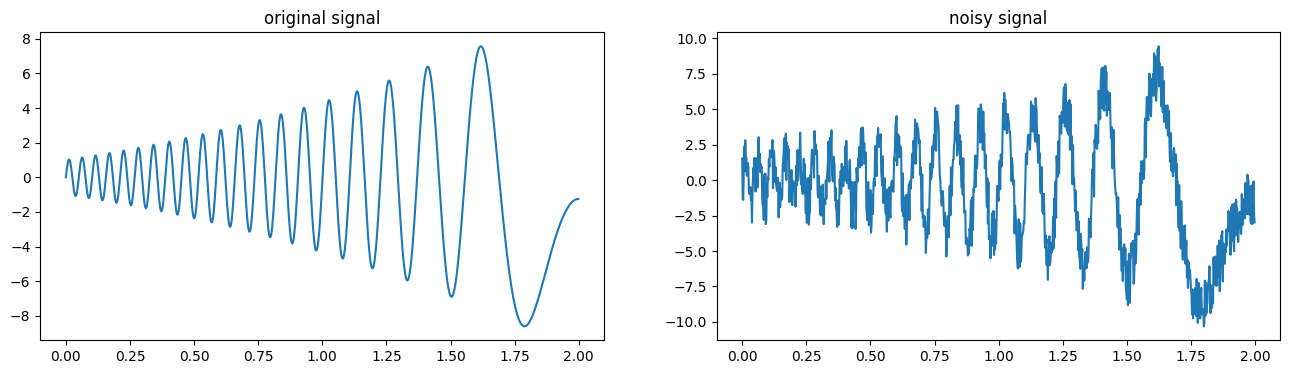

In [1]:
%matplotlib inline
# we will use numpy and matplotlib for all the following examples
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pywt

def doppler(freqs, dt, amp_inc=10, t0=0, f0=np.pi*2):
    t = np.arange(len(freqs)) * dt + t0
    amp = np.linspace(1, np.sqrt(amp_inc), len(freqs))**2
    sig = amp * np.sin(freqs * f0 * t)
    return t,sig

def noisify(sig, noise_amp=1):
    return sig + (np.random.random(len(sig))-0.5)*2*noise_amp
    

t_dop, sig_dop = doppler(np.arange(10,20,0.01)[::-1], 0.002)
sig_dop_n2 = noisify(sig_dop, noise_amp=2)
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(t_dop, sig_dop)
plt.title("original signal")
plt.subplot(122)
plt.plot(t_dop, sig_dop_n2)
plt.title("noisy signal")
plt.show()

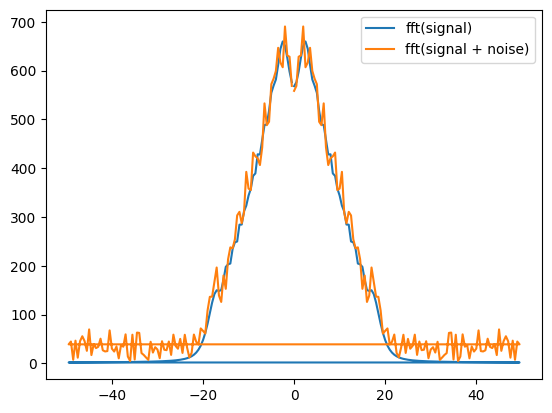

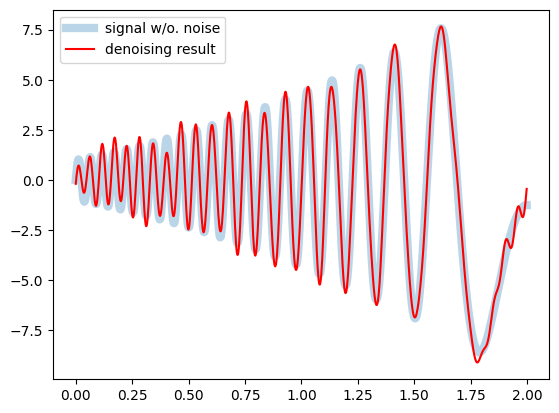

In [2]:
def fourier_denoising(sig, min_freq, max_freq, dt=1.0):
    trans = np.fft.fft(sig)
    freqs = np.fft.fftfreq(len(sig), d=dt)
    trans[np.where(np.logical_or(np.abs(freqs) < min_freq, np.abs(freqs) > max_freq))] = 0
    res = np.fft.ifft(trans)
    return res.real

fsig_dop = np.abs(np.fft.fft(sig_dop))
fsig_dop_n2 = np.abs(np.fft.fft(sig_dop_n2))
freqs_dop = np.fft.fftfreq(len(sig_dop),d=0.002)
idx = np.where(np.abs(freqs_dop) < 50)
plt.plot(freqs_dop[idx], fsig_dop[idx], label="fft(signal)")
plt.plot(freqs_dop[idx], fsig_dop_n2[idx], label="fft(signal + noise)")
plt.legend(loc="best")
plt.show()

fsig_dop_fden = fourier_denoising(sig_dop_n2, 0, 20, dt=0.002)
plt.plot(t_dop, sig_dop, lw=6, alpha=0.3, label="signal w/o. noise")
plt.plot(t_dop, fsig_dop_fden, "r-", label="denoising result")
plt.legend(loc="best")
plt.show()

In [3]:
# print the wavelet families available
print(pywt.families())
# print a list of available wavelets from one family
print(pywt.wavelist("sym"))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


In [4]:
# the haar wavelet
haar = pywt.Wavelet("haar")
h, g, hr, gr = haar.filter_bank
print("Haar wavelet highpass filter:",h)
print("Haar wavelet lowpass filter: ",g)
print(haar) # prints a summary of the wavelet properties

Haar wavelet highpass filter: [0.7071067811865476, 0.7071067811865476]
Haar wavelet lowpass filter:  [-0.7071067811865476, 0.7071067811865476]
Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


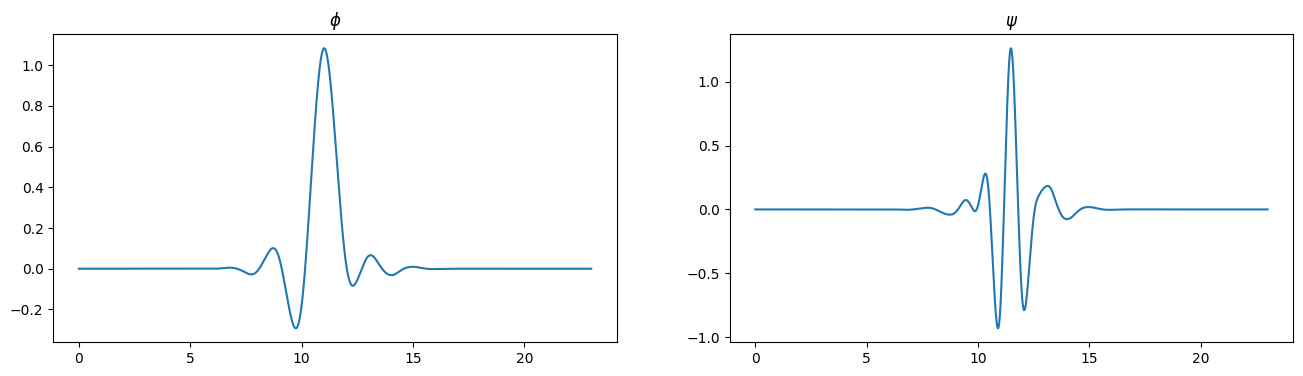

In [5]:
# Daubechies "least asymmetric" wavelets with 12 vanishing points
sym12 = pywt.Wavelet("sym12")
phi_s12, psi_s12, x_s12 = sym12.wavefun(8)
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("$\phi$")
plt.plot(x_s12,phi_s12)
plt.subplot(122)
plt.title("$\psi$")
plt.plot(x_s12,psi_s12)
plt.show()

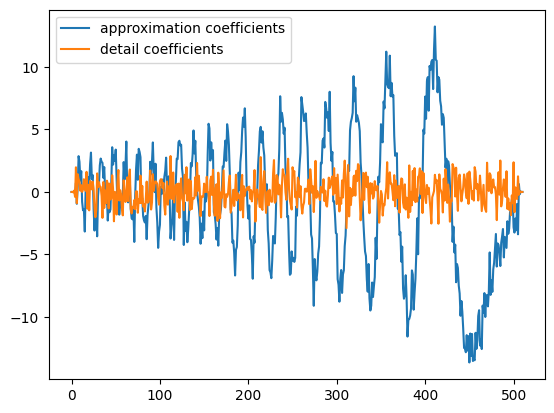

In [6]:
cA, cD = pywt.dwt(sig_dop_n2, "sym12", mode="zero")
plt.plot(cA, label="approximation coefficients")
plt.plot(cD, label="detail coefficients")
plt.legend(loc="best")
plt.show()

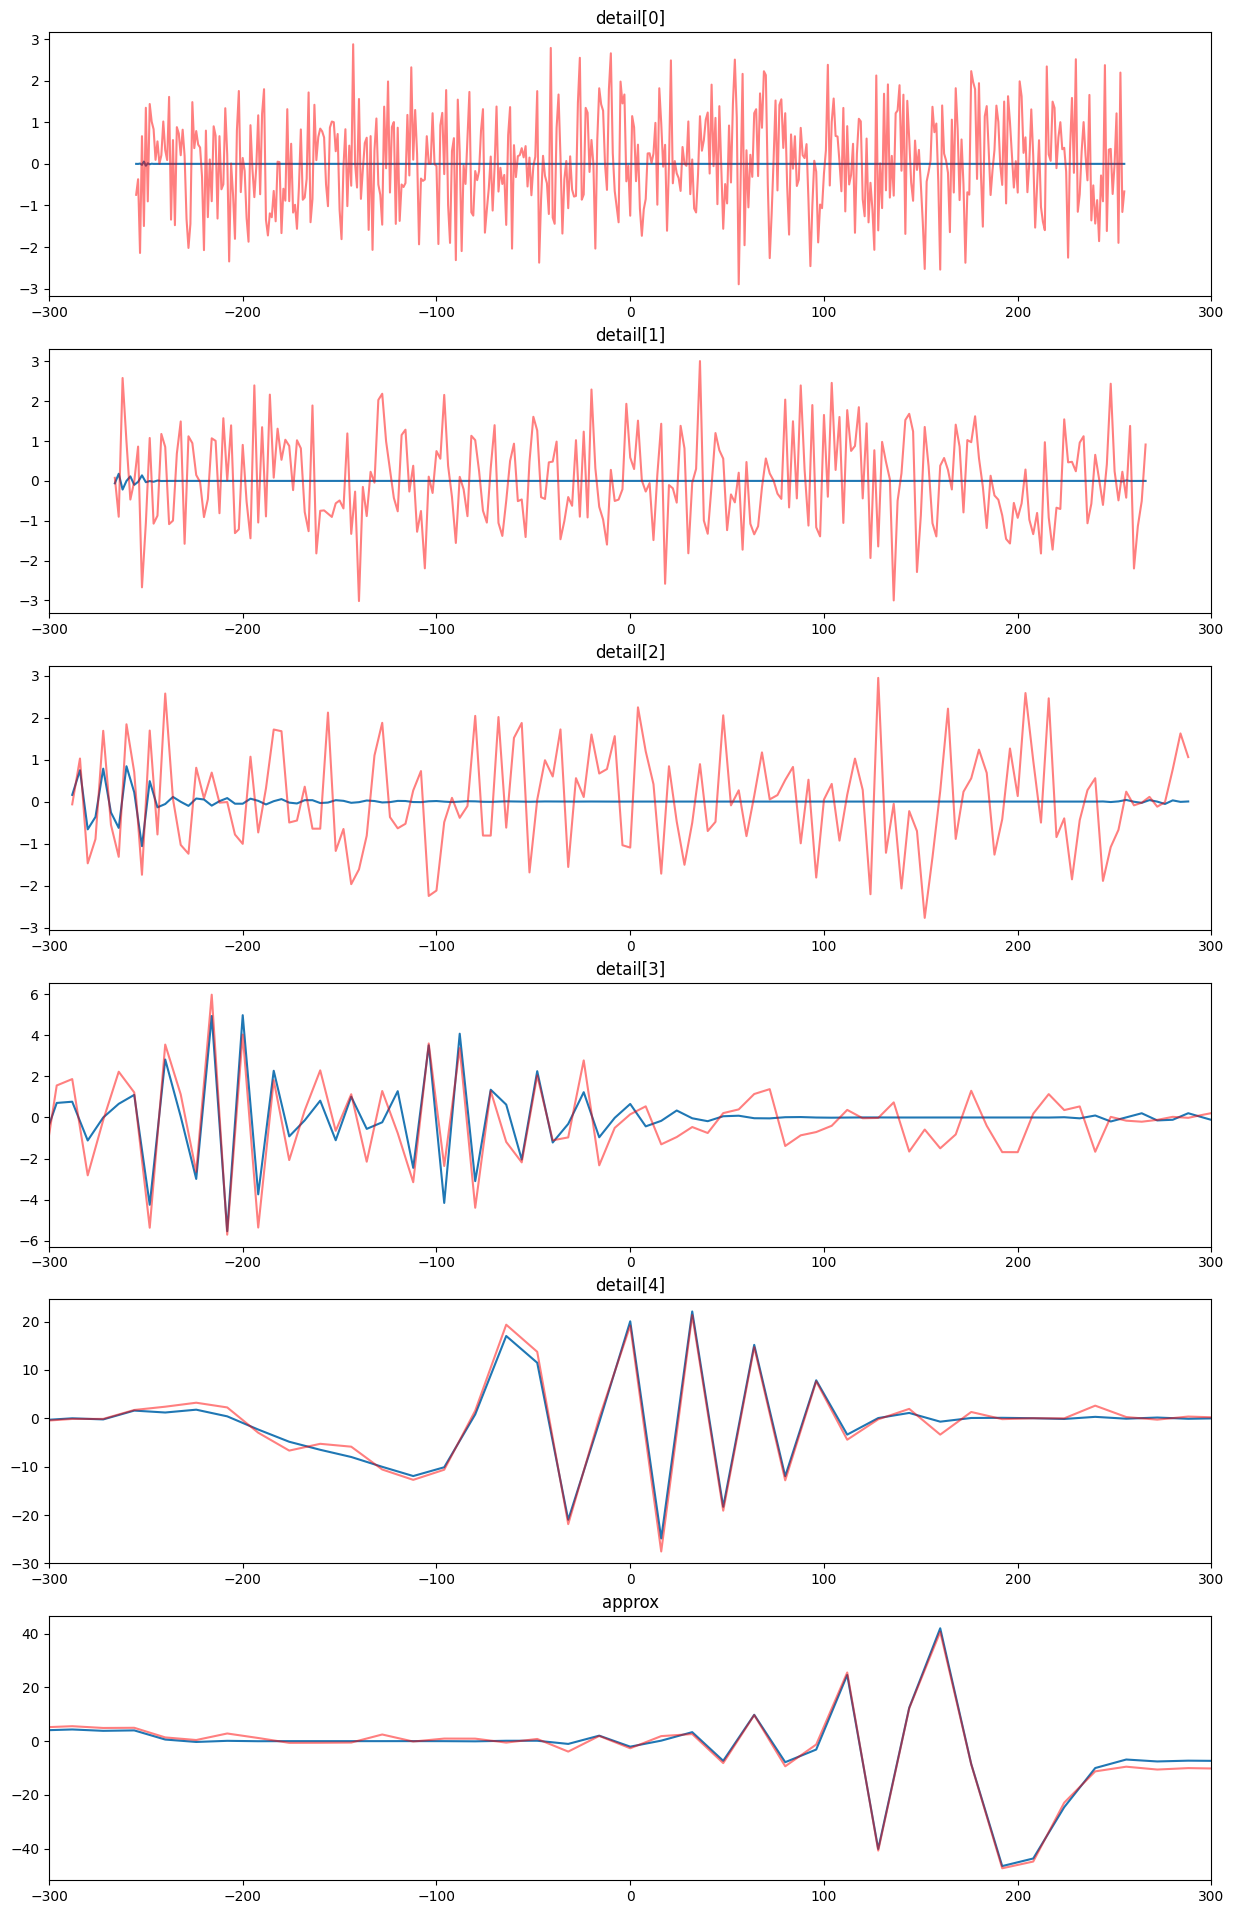

In [7]:
coeffs = pywt.wavedec(sig_dop, "sym12")
approx = coeffs[0]
details = coeffs[1:]
coeffs_n = pywt.wavedec(sig_dop_n2, "sym12")
approx_n = coeffs_n[0]
details_n = coeffs_n[1:]

def plot_dwt(details, approx, xlim=(-300,300), **line_kwargs):
    for i in range(len(details)):
        plt.subplot(len(details)+1,1,i+1)
        d = details[len(details)-1-i]
        half = len(d)//2
        xvals = np.arange(-half,-half+len(d))* 2**i
        plt.plot(xvals, d, **line_kwargs)
        plt.xlim(xlim)
        plt.title("detail[{}]".format(i))
    plt.subplot(len(details)+1,1,len(details)+1)
    plt.title("approx")
    plt.plot(xvals, approx, **line_kwargs)
    plt.xlim(xlim)

plt.figure(figsize=(15,24))
plot_dwt(details, approx)
plot_dwt(details_n, approx_n, color="red", alpha=0.5)
plt.show()

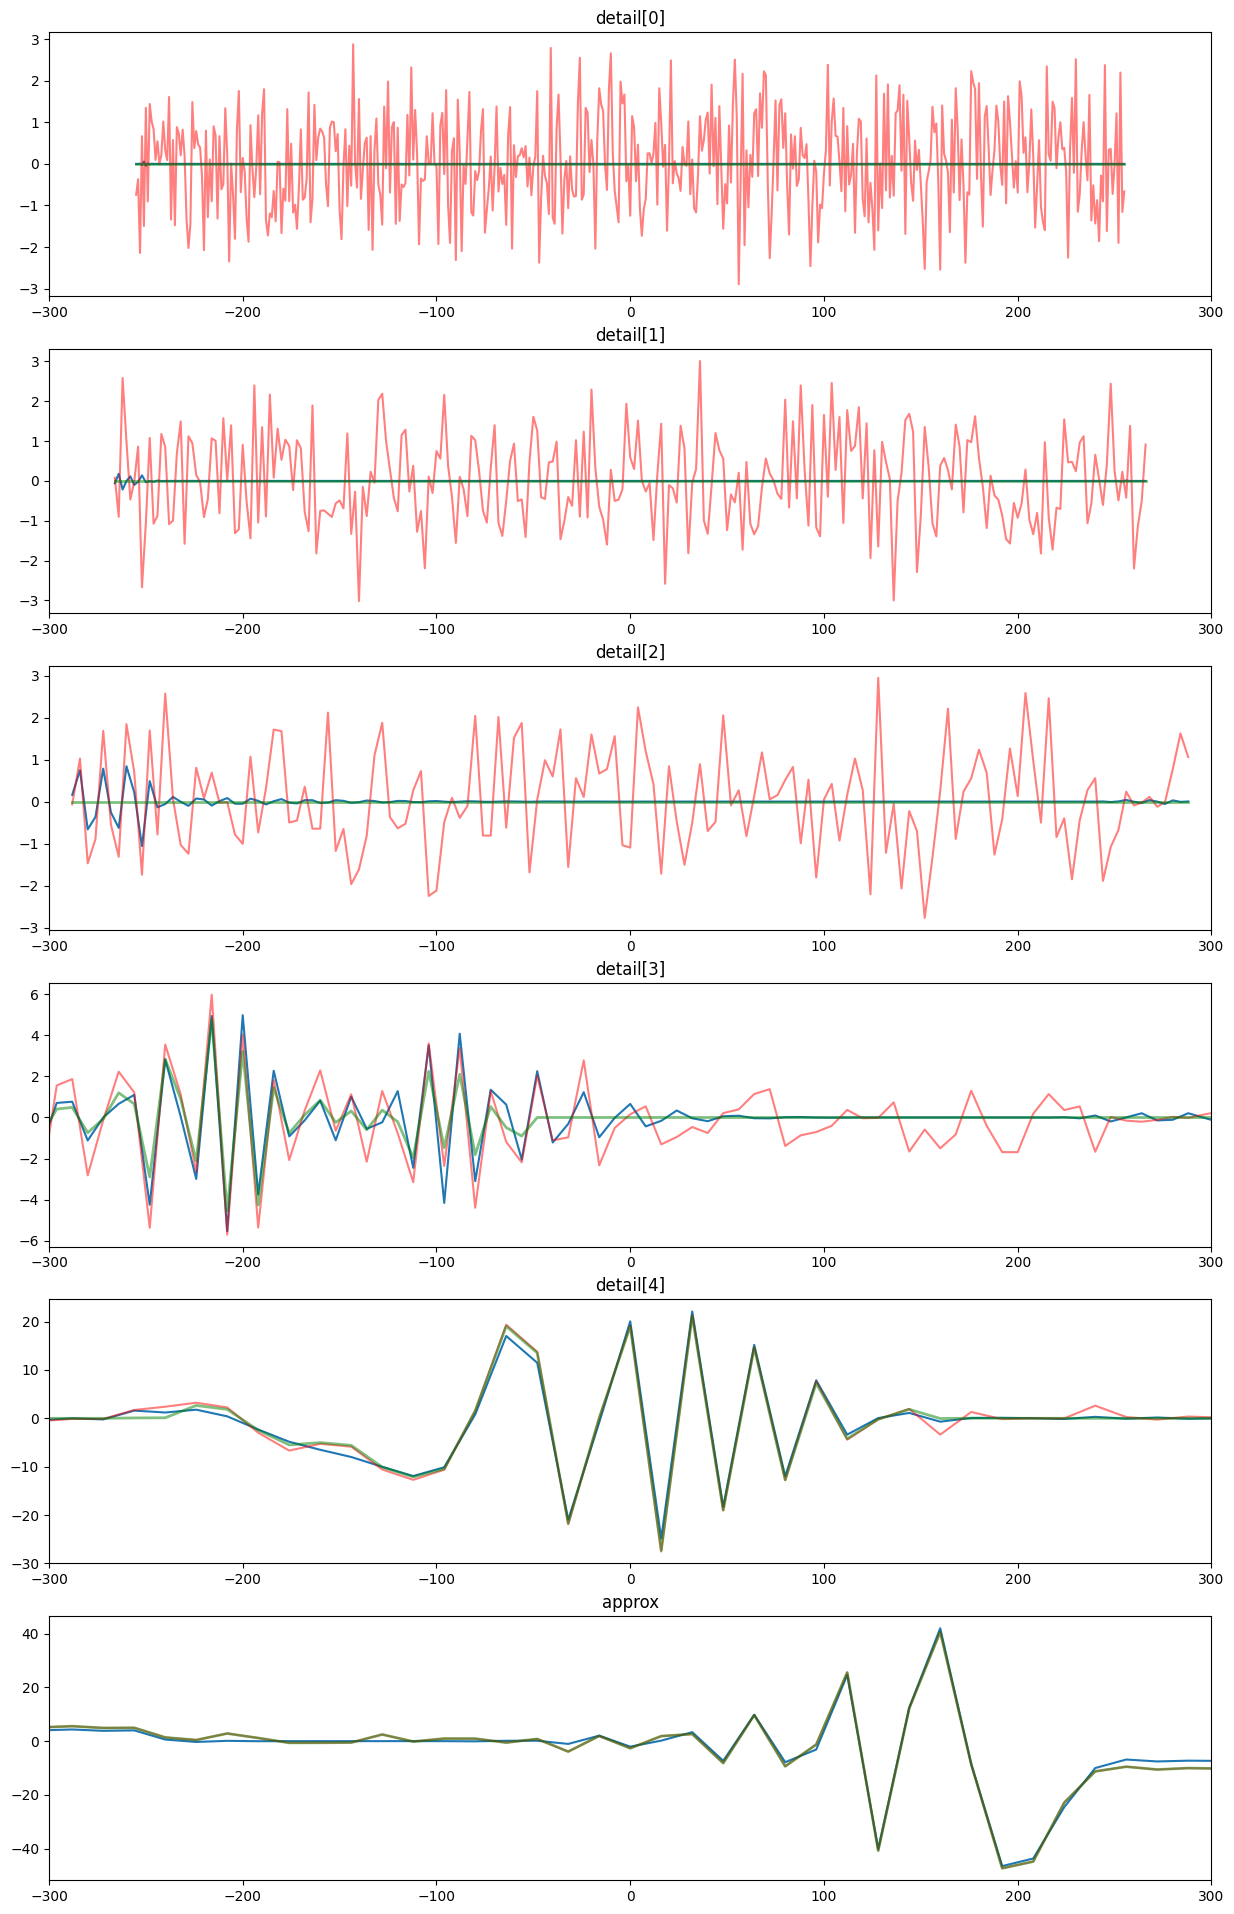

In [8]:
def neigh_block(details, n, sigma):
    res = []
    L0 = int(np.log2(n) // 2)
    L1 = max(1, L0 // 2)
    L = L0 + 2 * L1
    def nb_beta(sigma, L, detail):
        S2 = np.sum(detail ** 2)
        lmbd = 4.50524 # solution of lmbd - log(lmbd) = 3
        beta = (1 - lmbd * L * sigma**2 / S2)
        return max(0, beta)
    for d in details:
        d2 = d.copy()
        for start_b in range(0, len(d2), L0):
            end_b = min(len(d2), start_b + L0)
            start_B = start_b - L1
            end_B = start_B + L
            if start_B < 0:
                end_B -= start_B
                start_B = 0
            elif end_B > len(d2):
                start_B -= end_B - len(d2)
                end_B = len(d2)
            assert end_B - start_B == L
            d2[start_b:end_b] *= nb_beta(sigma, L, d2[start_B:end_B])
        res.append(d2)
    return res

details_nb = neigh_block(details_n, len(sig_dop), 0.8)
plt.figure(figsize=(15,24))
plot_dwt(details, approx)
plot_dwt(details_n, approx_n, color="red", alpha=0.5)
plot_dwt(details_nb, approx_n, color="green", alpha=0.5, lw=2)
plt.show()

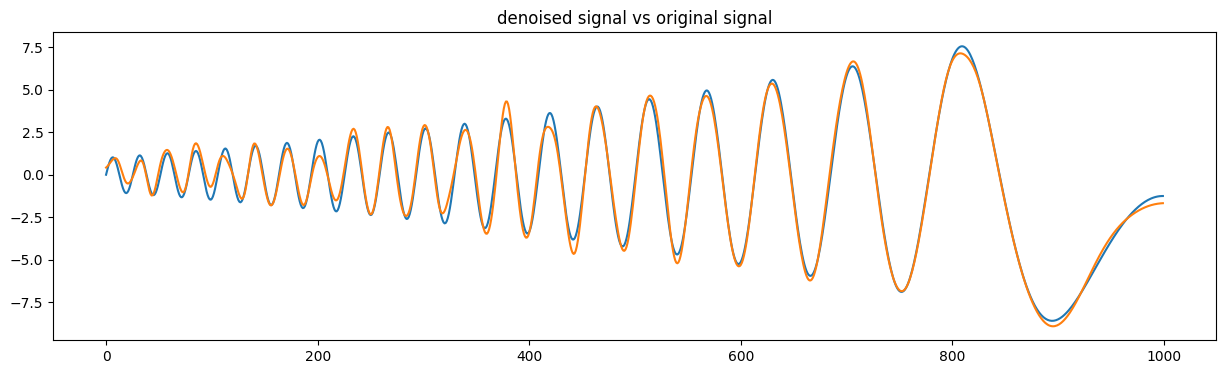

In [9]:
sig_dop_dn = pywt.waverec([approx_n] + details_nb, "sym12")
plt.figure(figsize=(15,4))
plt.title("denoised signal vs original signal")
plt.plot(sig_dop)
plt.plot(sig_dop_dn)
#plt.plot(fsig_dop_fden)
plt.show()